In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [61]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys 
sys.path.append('../../src')

In [62]:
adata = sc.read_h5ad('/Users/koush/Desktop/training_data/slideseq_mouse_lymphnode.h5ad')
# adata = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/slideseq_mouse_lymphnode.h5ad')
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram'
    uns: 'cell_thresholds', 'cell_type_colors', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [63]:
extra = pd.read_csv('banksy_cluster.csv', index_col=0)
adata.obs = adata.obs.join(extra.banksy_cluster)
adata.obs['banksy_cluster'] = adata.obs['banksy_cluster'].astype('category')
adata.obsm['X_umap'] = extra[['0', '1']].values

In [64]:
from spaceoracle.gene_factory import GeneFactory

gf = GeneFactory.from_json(
    adata, 
    # '/ix/djishnu/shared/djishnu_kor11/lasso_runs/slideseq_mouse_lymphnode/run_params.json', 
    '/Volumes/SSD/lasso_runs/slideseq_mouse_lymphnode/run_params.json', 
    override_params={
        'save_dir': '/Volumes/SSD/lasso_runs/slideseq_mouse_lymphnode'
        # 'save_dir': '/ix/djishnu/shared/djishnu_kor11/lasso_runs/slideseq_mouse_lymphnode'
    }
)
assert len(gf.queue.remaining_genes) == 0

In [65]:
from spaceoracle.beta import Betabase

bdb = Betabase(
    gf.adata, 
    gf.save_dir, 
    subsample=None, 
    float16=True, 
    obs_names=adata.obs_names,
    auto_load=False
)

### Cell type

In [10]:
interactions = {}

for ct in adata.obs.cell_type.unique():
    interactions[ct] = bdb.collect_interactions(cell_type=ct, annot='cell_type')

In [24]:
from spaceoracle.plotting.cartography import Cartography

In [49]:
import matplotlib.pyplot as plt
import random
cluster_colors = {i: plt.cm.tab10(random.random()) for i in [0, 2, 4, 7, 9, 11, 13, 15, 17, 20, 22]}
color_dict = {
    'B': '#9e18f1',
    'Resting T': '#a5b146',
    'Tfh': '#1032ee',
    'CD8+ T': '#9a6834',
    'Treg': '#5db852',
    'Th2': '#cd4263',
    'DC': '#5d6cb1',
}
chart = Cartography(adata[adata.obs.cell_type.isin(['Th2'])], cluster_colors)

/Users/koush/Projects/SpaceOracle/notebooks/mouse_lymphnode_slideseq/../../src/spaceoracle/plotting/cartography.py:664: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  handles = [plt.scatter([], [], c=alt_colors[label], label=label) for label in sorted(all_cts.unique())]
/Users/koush/Projects/SpaceOracle/notebooks/mouse_lymphnode_slideseq/../../src/spaceoracle/plotting/cartography.py:664: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all po

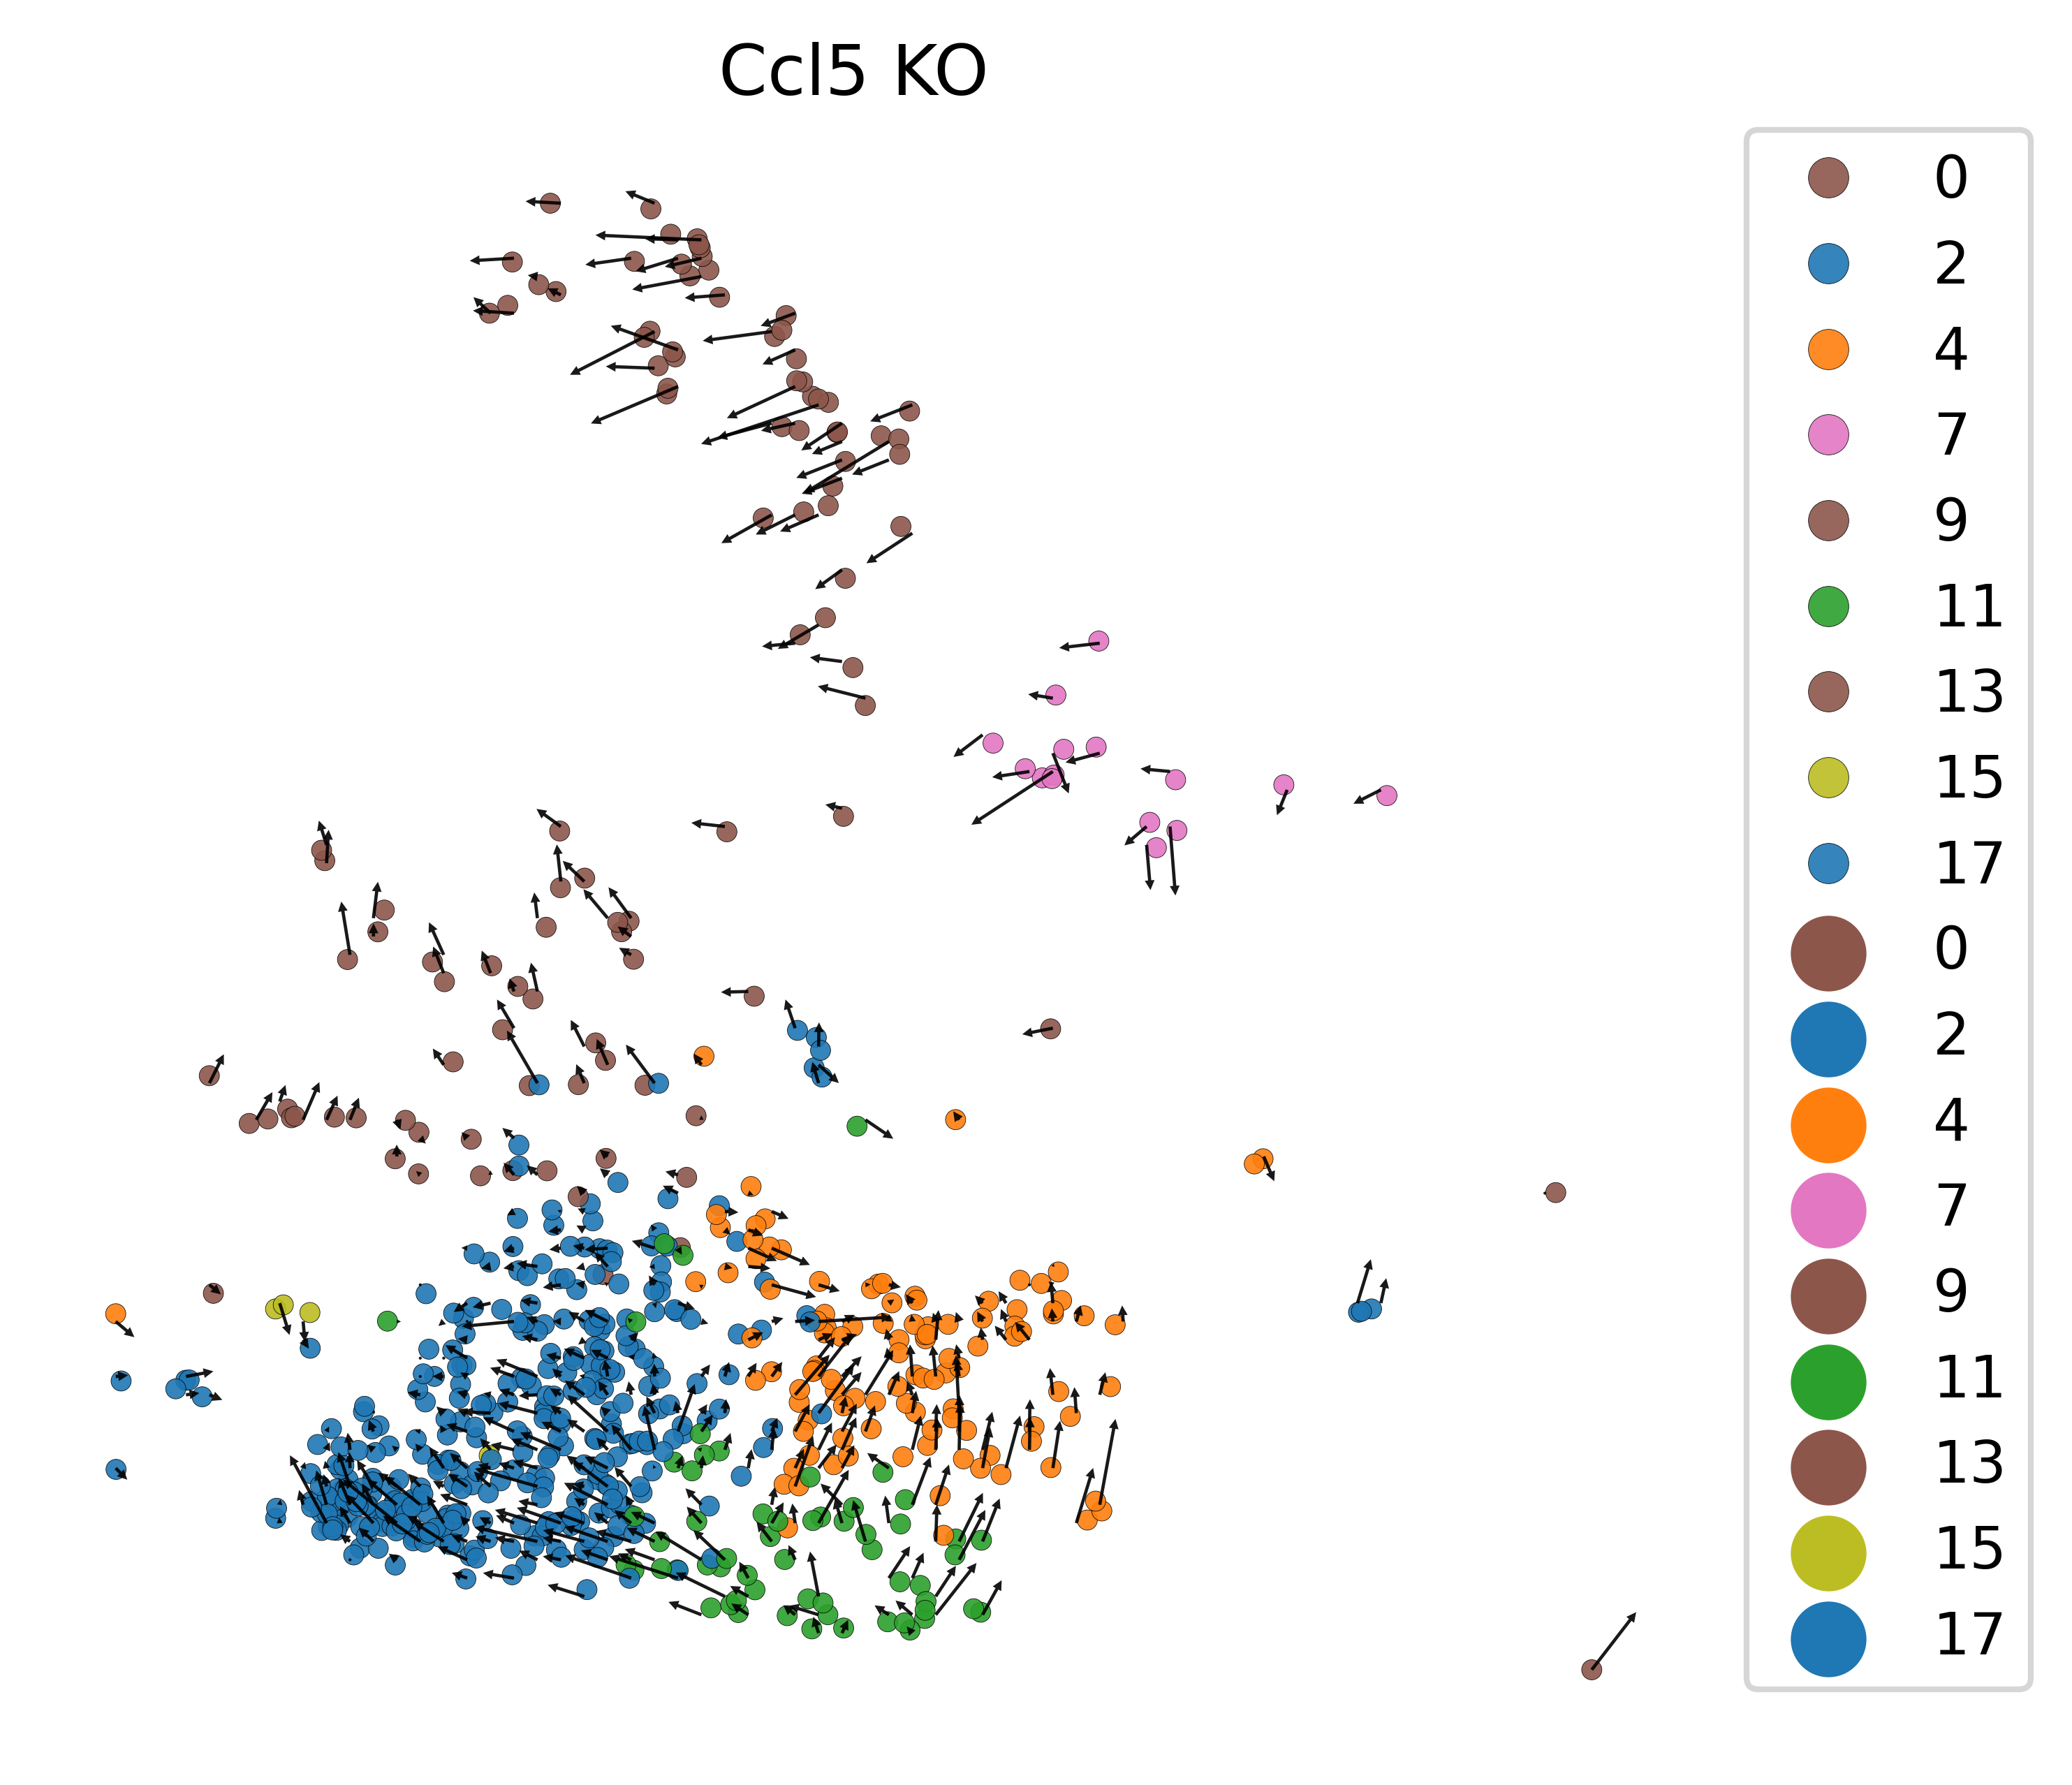

In [50]:
kotarget = 'Ccl5'
perturbed_df = pd.read_parquet(f'/Volumes/SSD/genome_screens/slideseq_mouse_lymphnode/{kotarget}_4n_0x.parquet')
# perturbed_df[kotarget] = adata.to_df(layer='imputed_count')[kotarget]

ax = chart.plot_umap_quiver(
    perturb_target=kotarget,
    grid_scale=2.5,
    vector_scale=0.8,
    figsize=(5, 5), 
    n_neighbors=100,
    hue='banksy_cluster',
    alpha=0.9,
    remove_null=True,
    scatter_size=12,
    perturbed_df=perturbed_df,
    # betadata_path='/Volumes/SSD/genome_screens/slideseq_mouse_lymphnode',
    legend_on_loc=False,
    rescale=1e12
)
plt.title(f'{kotarget} KO')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., markerscale=2)
plt.show()

In [54]:
import warnings
warnings.filterwarnings('ignore')

In [56]:
bdb.load_betadata('Ccr4')[adata.obs.cell_type == 'Th2'].mean().sort_values(ascending=True).head(10)

beta_Irf2    -0.072228
beta_Pax5    -0.054387
beta_Mef2c   -0.037145
beta_Grhl1   -0.034763
beta_Rxra    -0.033045
beta_Nr1h3   -0.022237
beta_Cebpb   -0.021746
beta_Stat2   -0.014972
beta_Hes5    -0.007715
beta_Brf1    -0.006805
dtype: float32

In [58]:
bdb.load_betadata('Ccr7')[adata.obs.cell_type == 'Th2'].mean().sort_values(ascending=True).head(10)

beta_Mef2c   -0.509833
beta_Klf6    -0.315938
beta_Pax5    -0.260926
beta_Foxj2   -0.137629
beta_Hic1    -0.136697
beta_Id1     -0.113814
beta_Id4     -0.073313
beta_Rreb1   -0.031330
beta_Gata2   -0.025961
beta_Klf4    -0.013444
dtype: float32

In [21]:
bdb.load_betadata('Ccr7')[adata.obs.cell_type == 'Th2'].mean().sort_values(ascending=True).head(25)

beta_Mef2c          -0.509833
beta_Klf6           -0.315938
beta_Pax5           -0.260926
beta_Foxj2          -0.137629
beta_Hic1           -0.136697
beta_Id1            -0.113814
beta_Id4            -0.073313
beta_Rreb1          -0.031330
beta_Gata2          -0.025961
beta_Klf4           -0.013444
beta_Hes5           -0.012789
beta_Mif$Cd74       -0.000087
beta_C3$Itgb2       -0.000058
beta_Il16$Cd4       -0.000055
beta_Lgals9$Ptprc   -0.000045
beta_Ccl5$Ccr4      -0.000031
beta_Mdk$Ncl        -0.000028
beta_Ccl22$Ccr4     -0.000017
beta_Il2$Il2rb      -0.000007
beta_Mif$Cd44       -0.000004
beta_Lgals9$Cd44    -0.000003
beta_Ccl17$Ccr4     -0.000002
beta_C3$Itgax       -0.000002
beta_Tgfb1$Tgfbr2   -0.000002
beta_Il15$Il2rb     -0.000001
dtype: float32

In [8]:
interactions['Th2'].query('gene=="Il2ra"').groupby('interaction').sum().sort_values(
    by='beta', ascending=False).head(10)

,gene,beta,interaction_type
interaction,,,
beta_C3$Itgb2,Il2ra,0.003608,ligand-receptor
beta_Ccl5$Ccr4,Il2ra,0.001757,ligand-receptor
beta_Ccl22$Ccr4,Il2ra,0.001535,ligand-receptor
beta_Mdk$Ncl,Il2ra,0.000748,ligand-receptor
beta_Il2$Il2rb,Il2ra,0.000439,ligand-receptor
beta_C3$Itgam,Il2ra,0.000243,ligand-receptor
beta_Cxcl13$Cxcr3,Il2ra,0.000228,ligand-receptor
beta_Nampt$Itgb1,Il2ra,0.000141,ligand-receptor
beta_Ccl17$Ccr4,Il2ra,0.000137,ligand-receptor


In [28]:
# dfr = interactions['Th2'].query('gene.isin(["Il2ra", "Il2rb", "Il2rg"])').groupby(
#     'interaction').sum().sort_values(
#     by='beta', ascending=False)

dfr = interactions['Th2'].query('gene.isin(["Il2ra", "Il2rb", "Il2rg", "Gata3"])').groupby(
    'interaction').sum().sort_values(
    by='beta', ascending=False)

dfr['beta'] = dfr['beta'] * 100
dfr.index = dfr.index.str.replace('beta_', '').str.replace('$', '-')

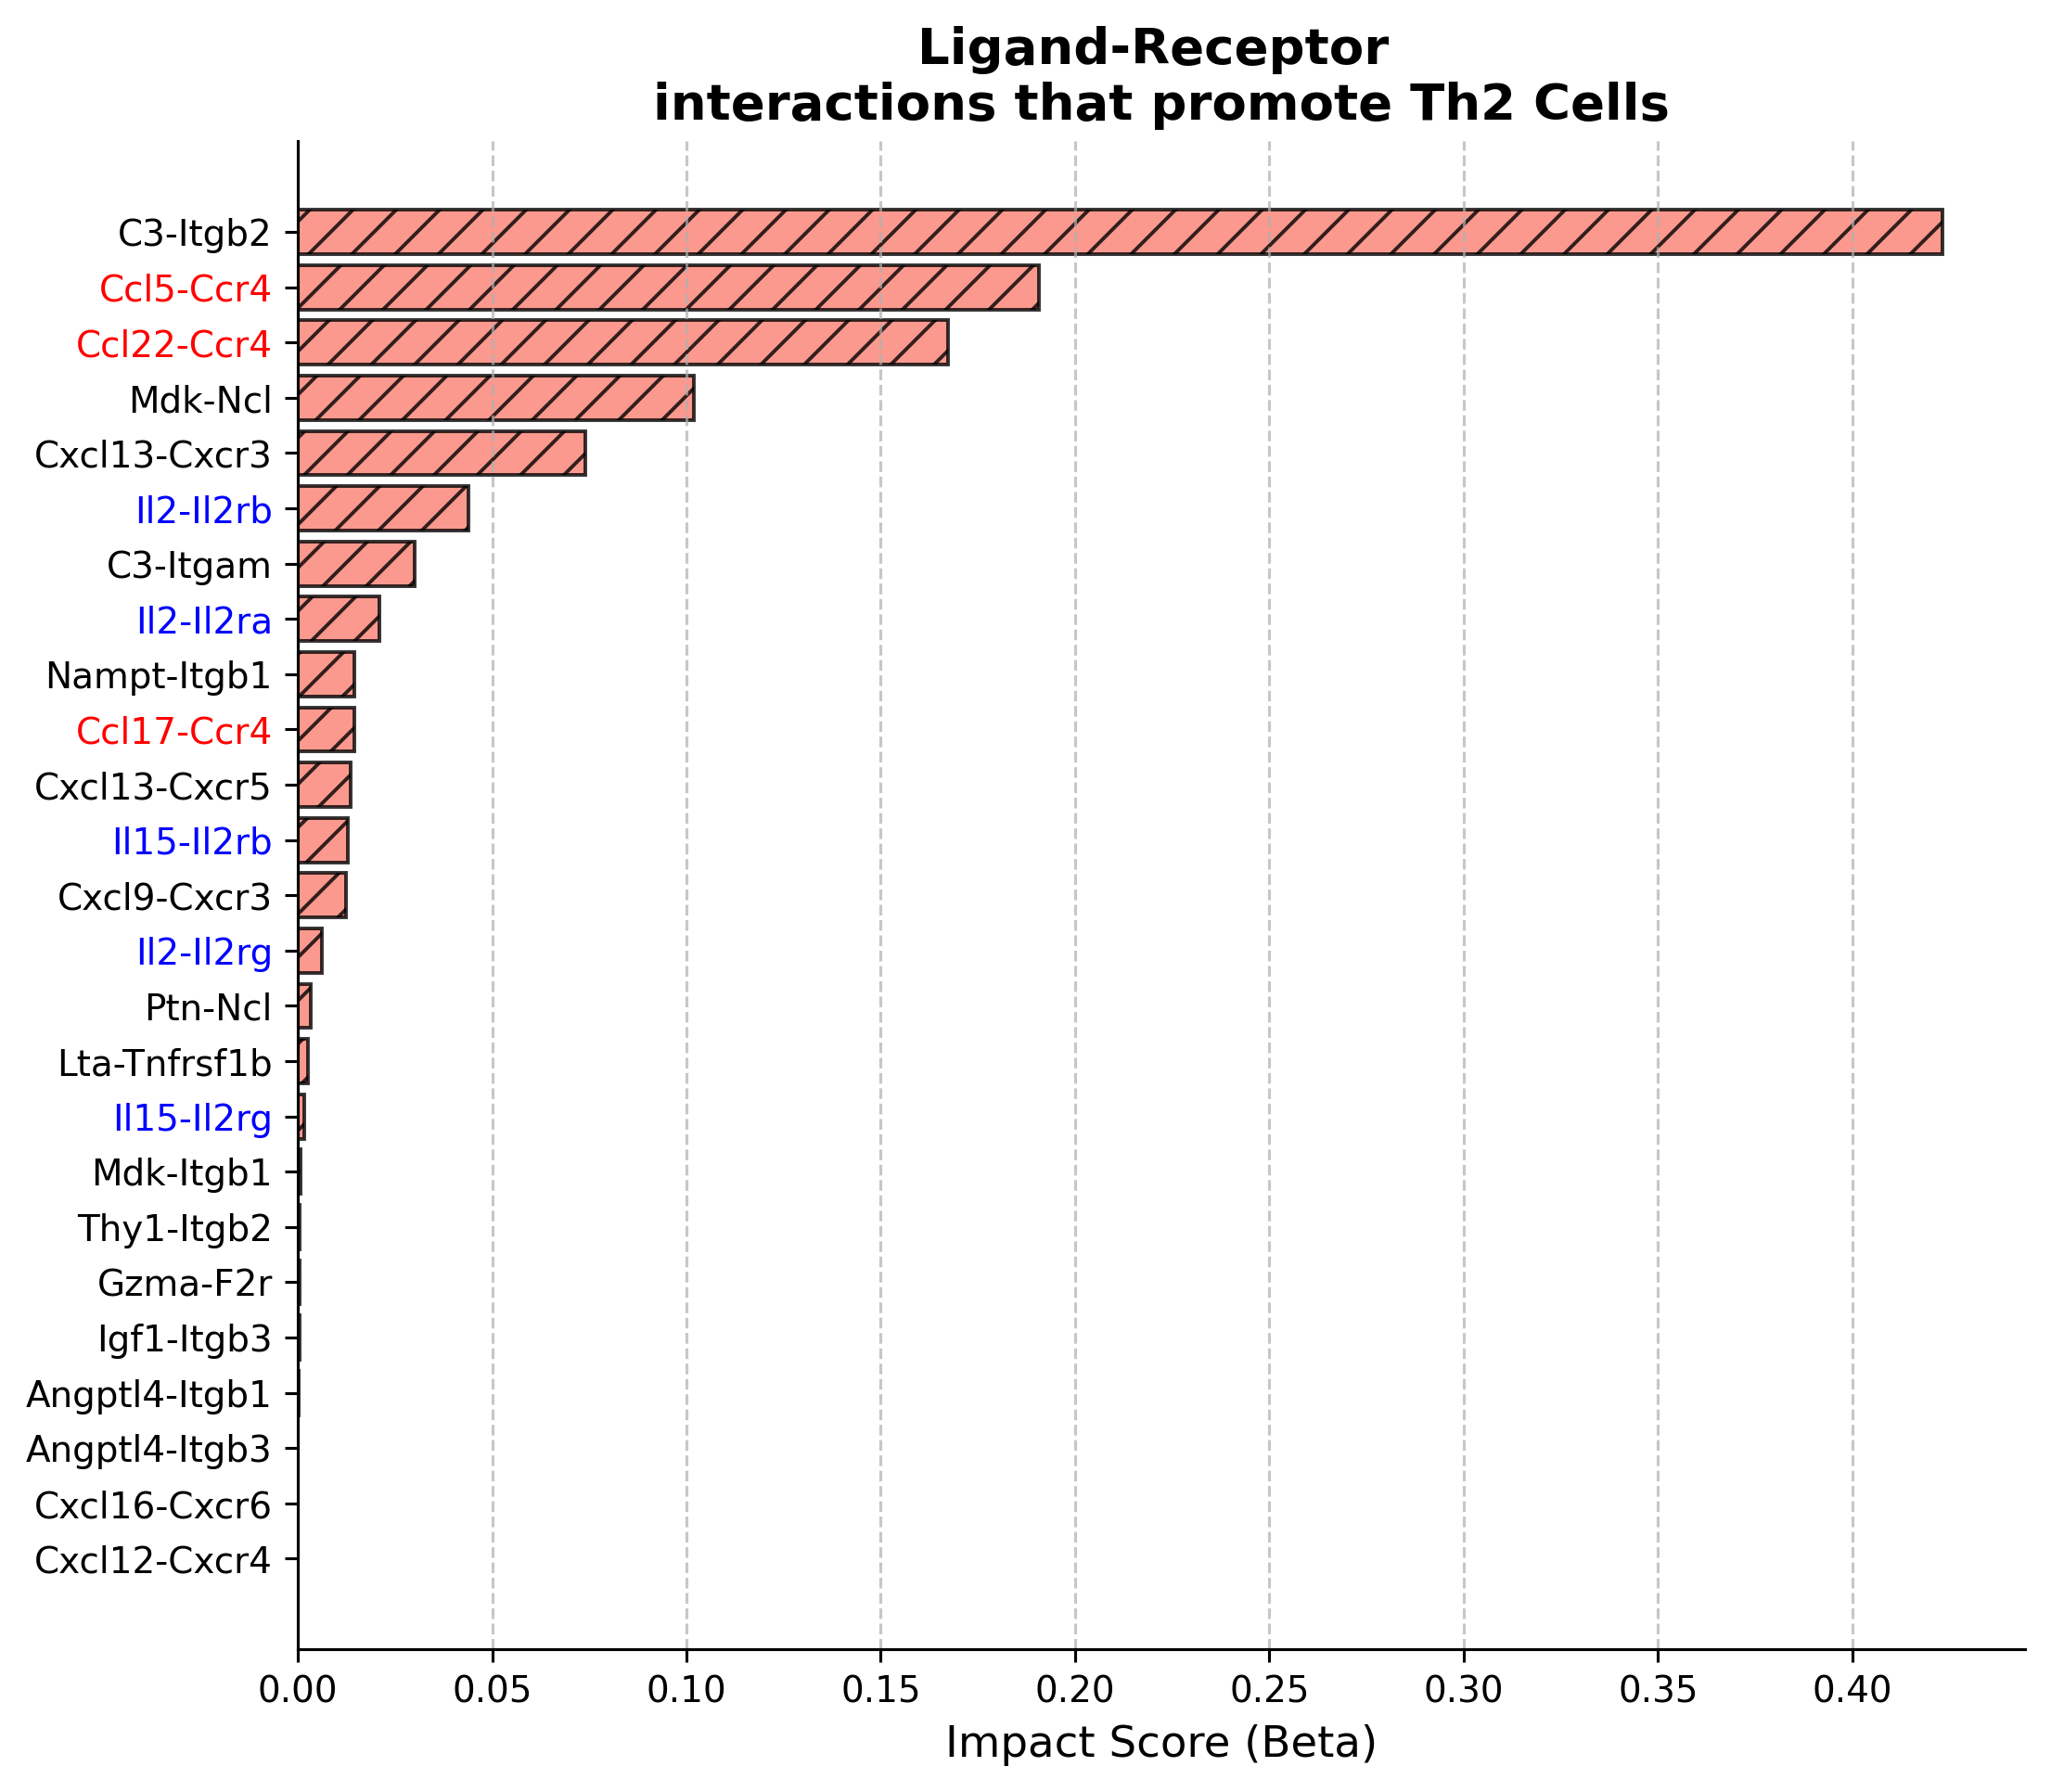

In [29]:
top_interactions = dfr[dfr['beta'] > 0].sort_values(
    by='beta', ascending=False).head(25)[::-1]

fig, ax = plt.subplots(figsize=(8, 7), dpi=140)
bars = ax.barh(top_interactions.index, top_interactions['beta'], 
    color='salmon', edgecolor='black', alpha=0.8, hatch='//')

ylabels = [label.get_text() for label in ax.get_yticklabels()]

for label in ylabels:
    if 'Ccr4' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('red')
        
    if 'Il2ra' in label or 'Il2rb' in label or 'Il2' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('blue')
        
ax.set_xlabel('Impact Score (Beta)', fontsize=12)
ax.set_title('Ligand-Receptor \ninteractions that promote Th2 phenotype', fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

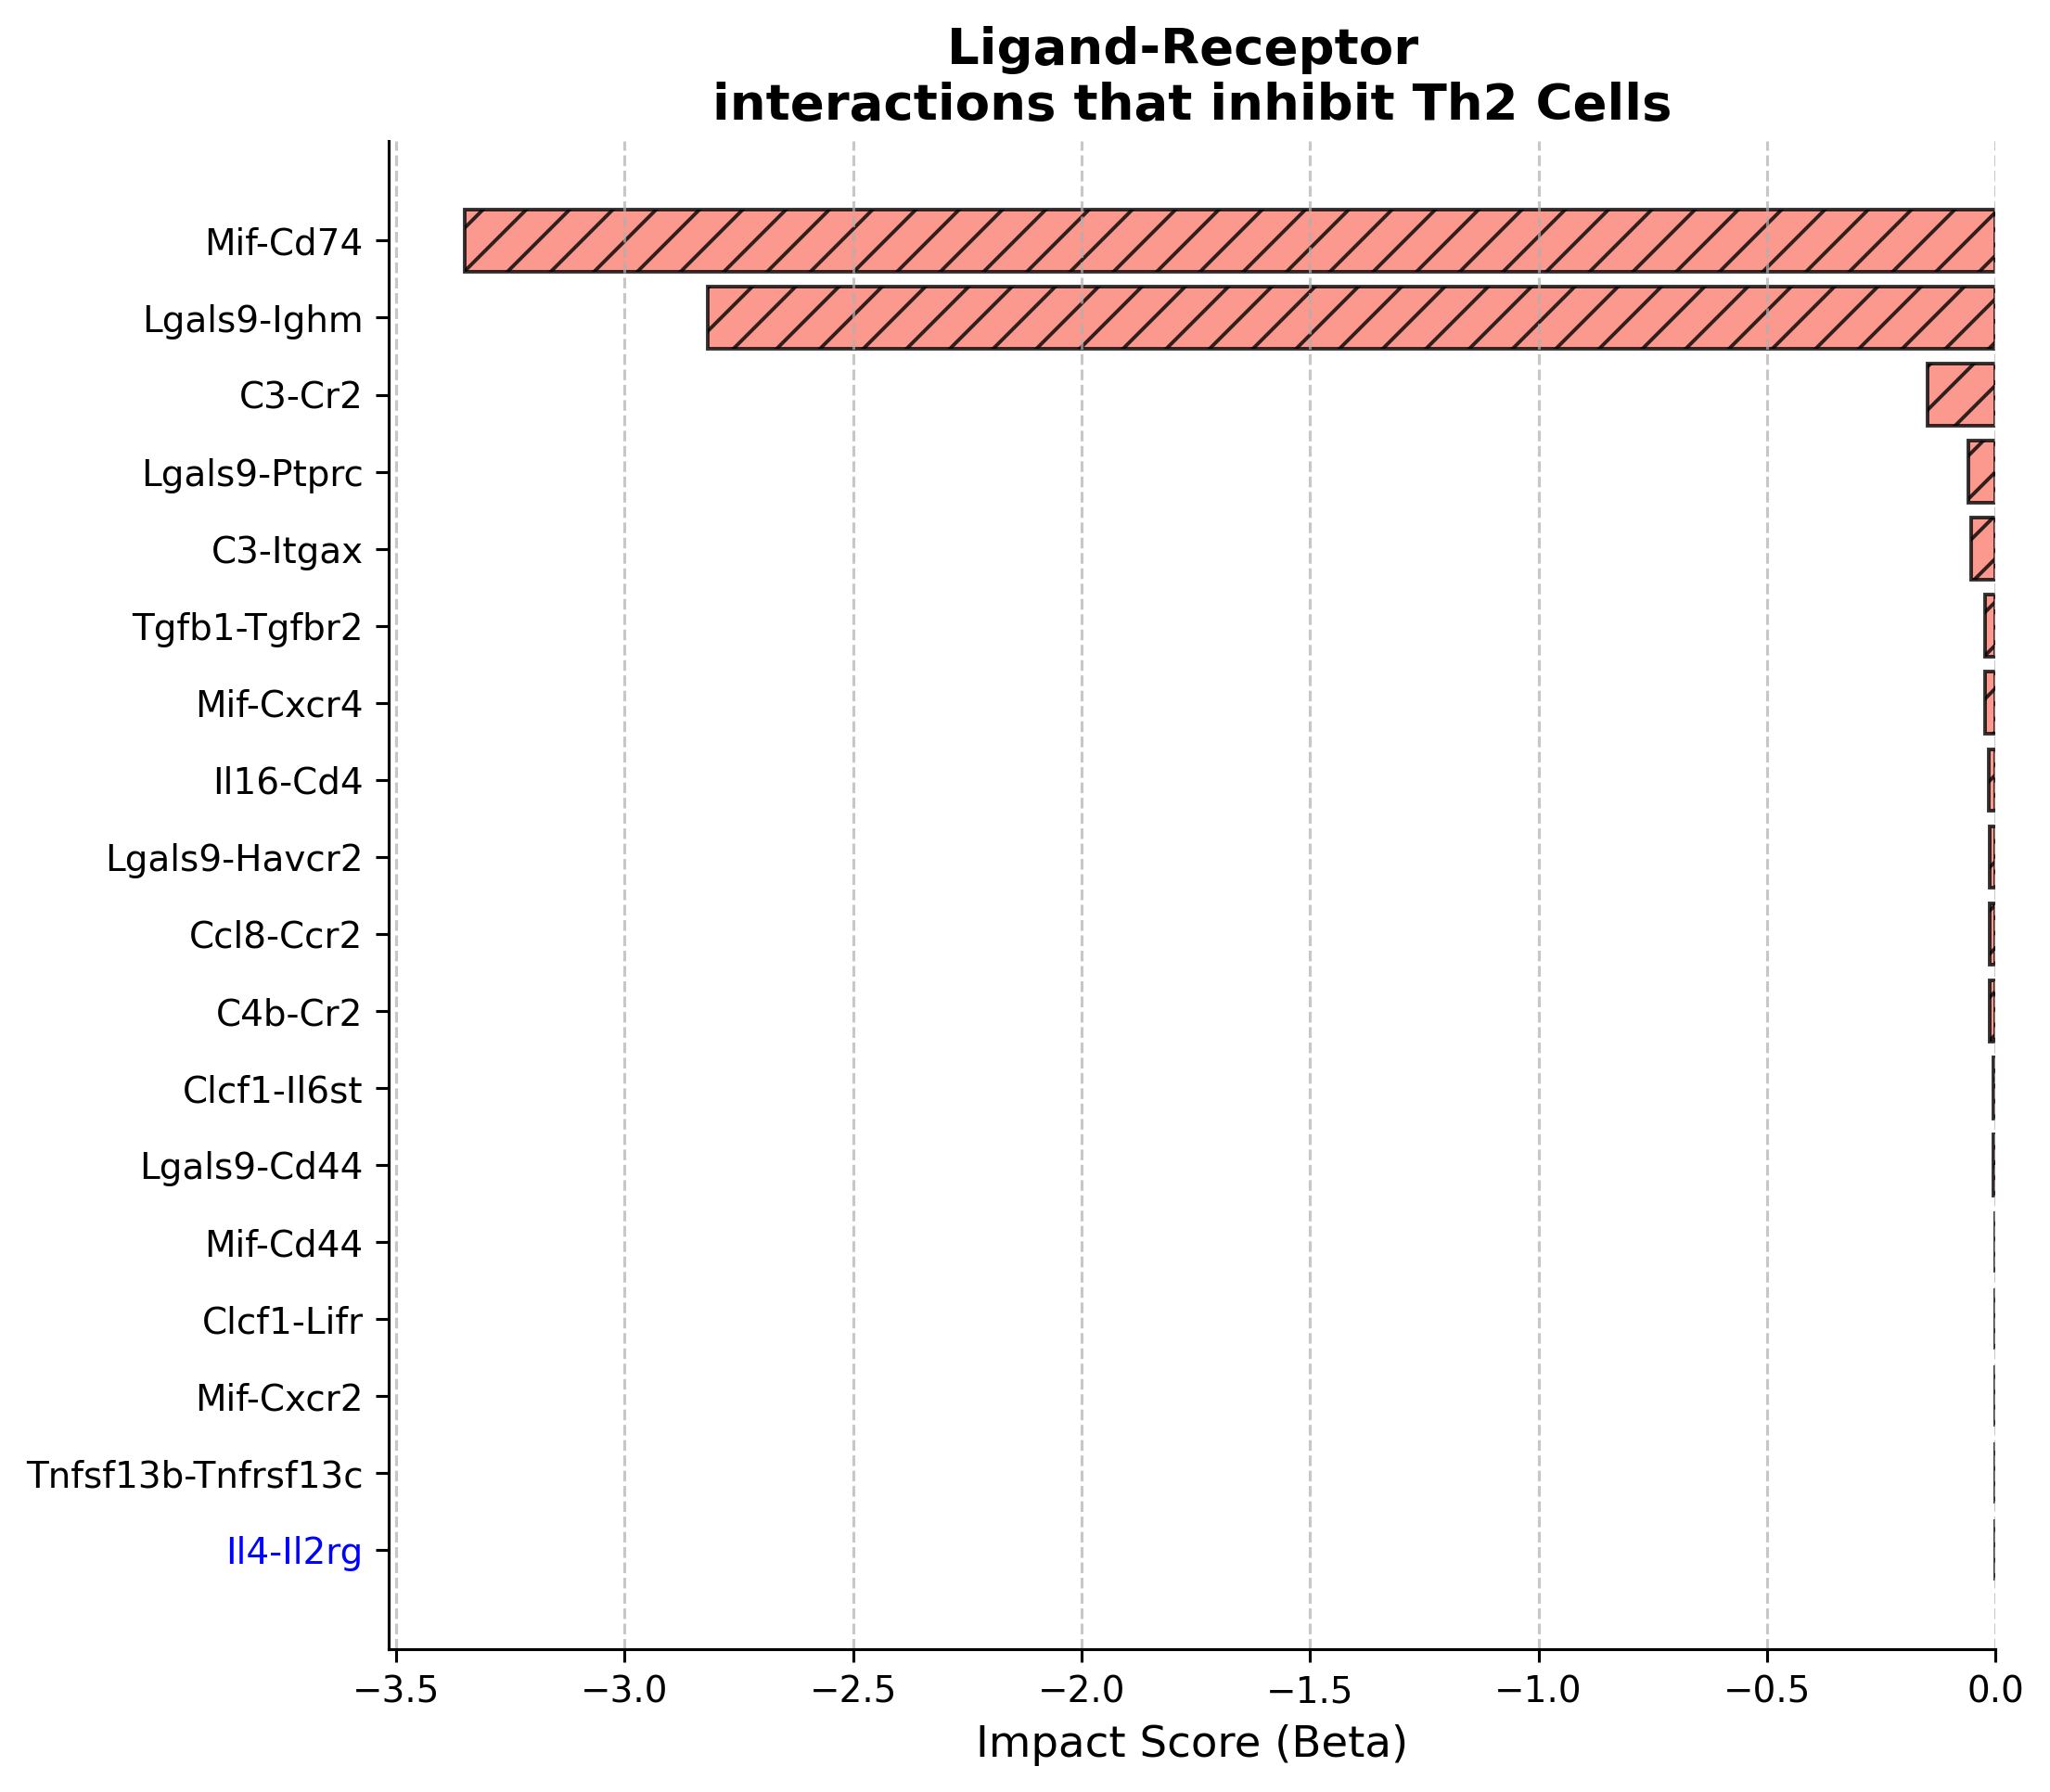

In [30]:
top_interactions = dfr[dfr['beta'] < 0].sort_values(
    by='beta', ascending=True).head(25)[::-1]

fig, ax = plt.subplots(figsize=(8, 7), dpi=140)
bars = ax.barh(top_interactions.index, top_interactions['beta'], 
    color='salmon', edgecolor='black', alpha=0.8, hatch='//')

ylabels = [label.get_text() for label in ax.get_yticklabels()]

for label in ylabels:
    if 'Ccr4' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('red')
        
    if 'Il2ra' in label or 'Il2rb' in label or 'Il2' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('blue')
        
ax.set_xlabel('Impact Score (Beta)', fontsize=12)
ax.set_title('Ligand-Receptor \ninteractions that inhibit Th2 Cells', fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

In [22]:
dfr = interactions['Tfh'].query('gene.isin(["Icos", "Bcl6", "Cxcr5", "Pdcd1"])').groupby(
    'interaction').sum().sort_values(
    by='beta', ascending=False)


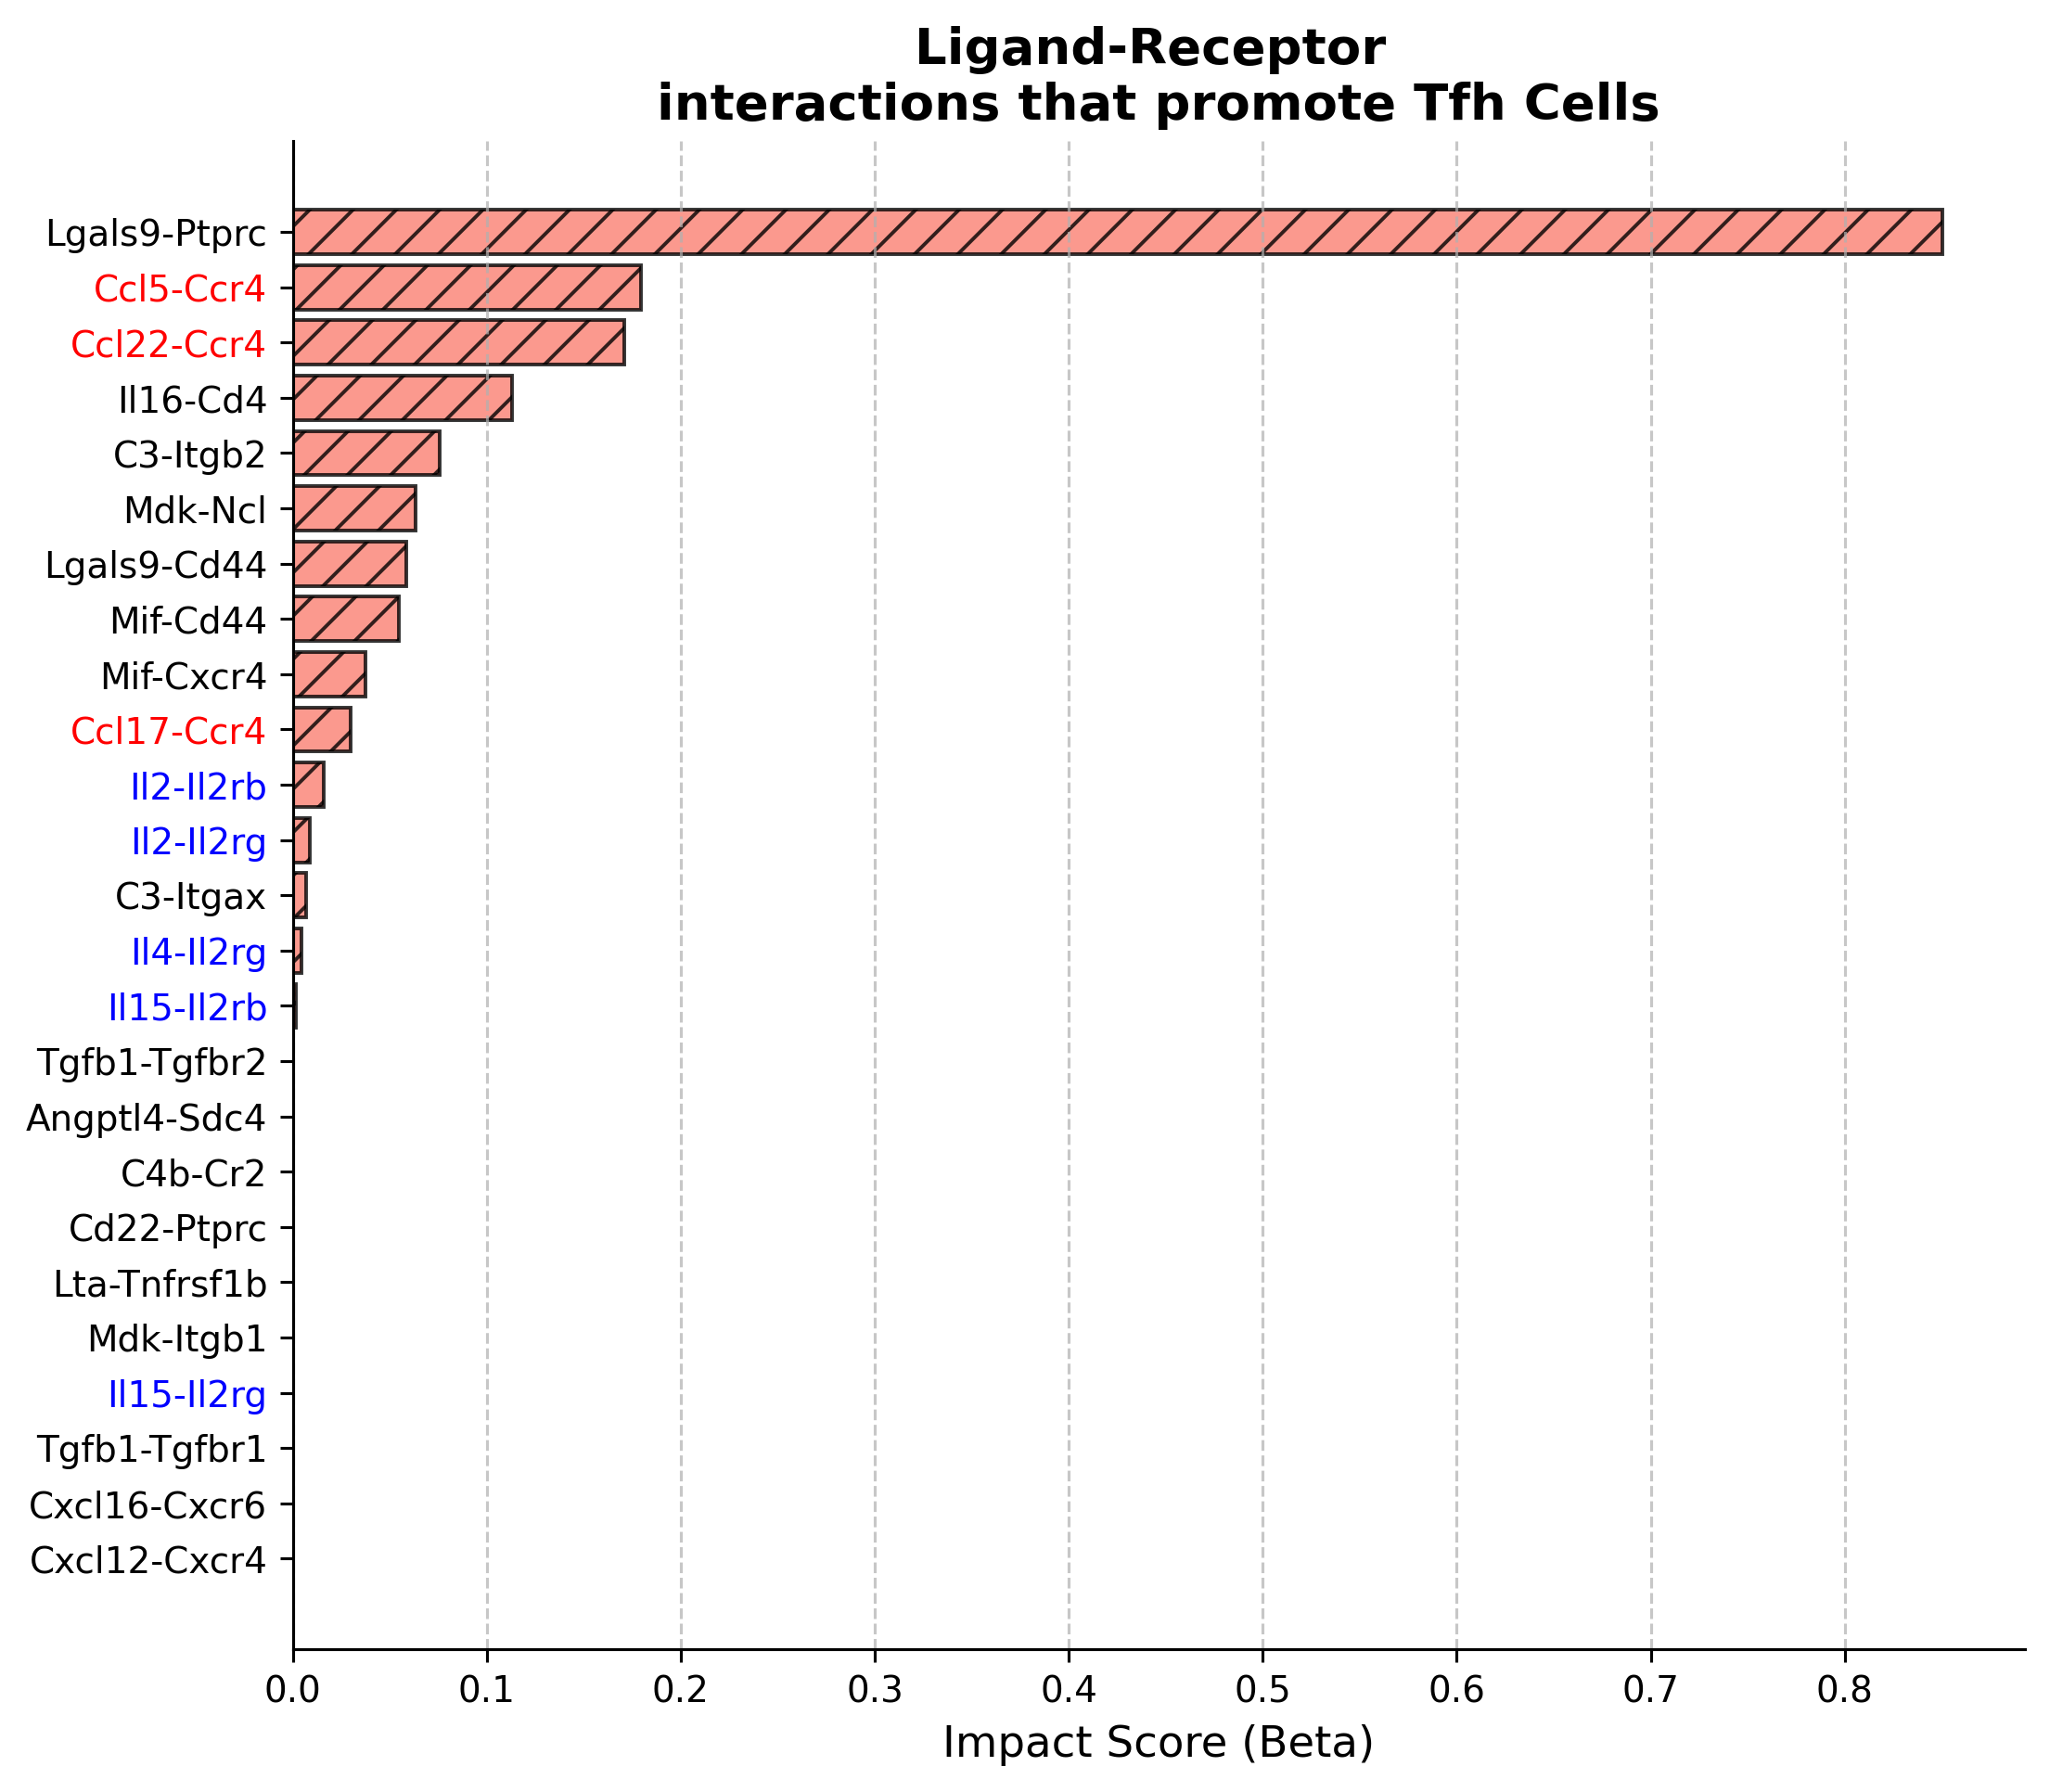

In [27]:
top_interactions = dfr[dfr['beta'] > 0].sort_values(
    by='beta', ascending=False).head(25)[::-1]

fig, ax = plt.subplots(figsize=(8, 7), dpi=140)
bars = ax.barh(top_interactions.index, top_interactions['beta'], 
    color='salmon', edgecolor='black', alpha=0.8, hatch='//')

ylabels = [label.get_text() for label in ax.get_yticklabels()]

for label in ylabels:
    if 'Ccr4' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('red')
        
    if 'Il2ra' in label or 'Il2rb' in label or 'Il2' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('blue')
        
ax.set_xlabel('Impact Score (Beta)', fontsize=12)
ax.set_title('Ligand-Receptor \ninteractions that promote Tfh Cells', fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

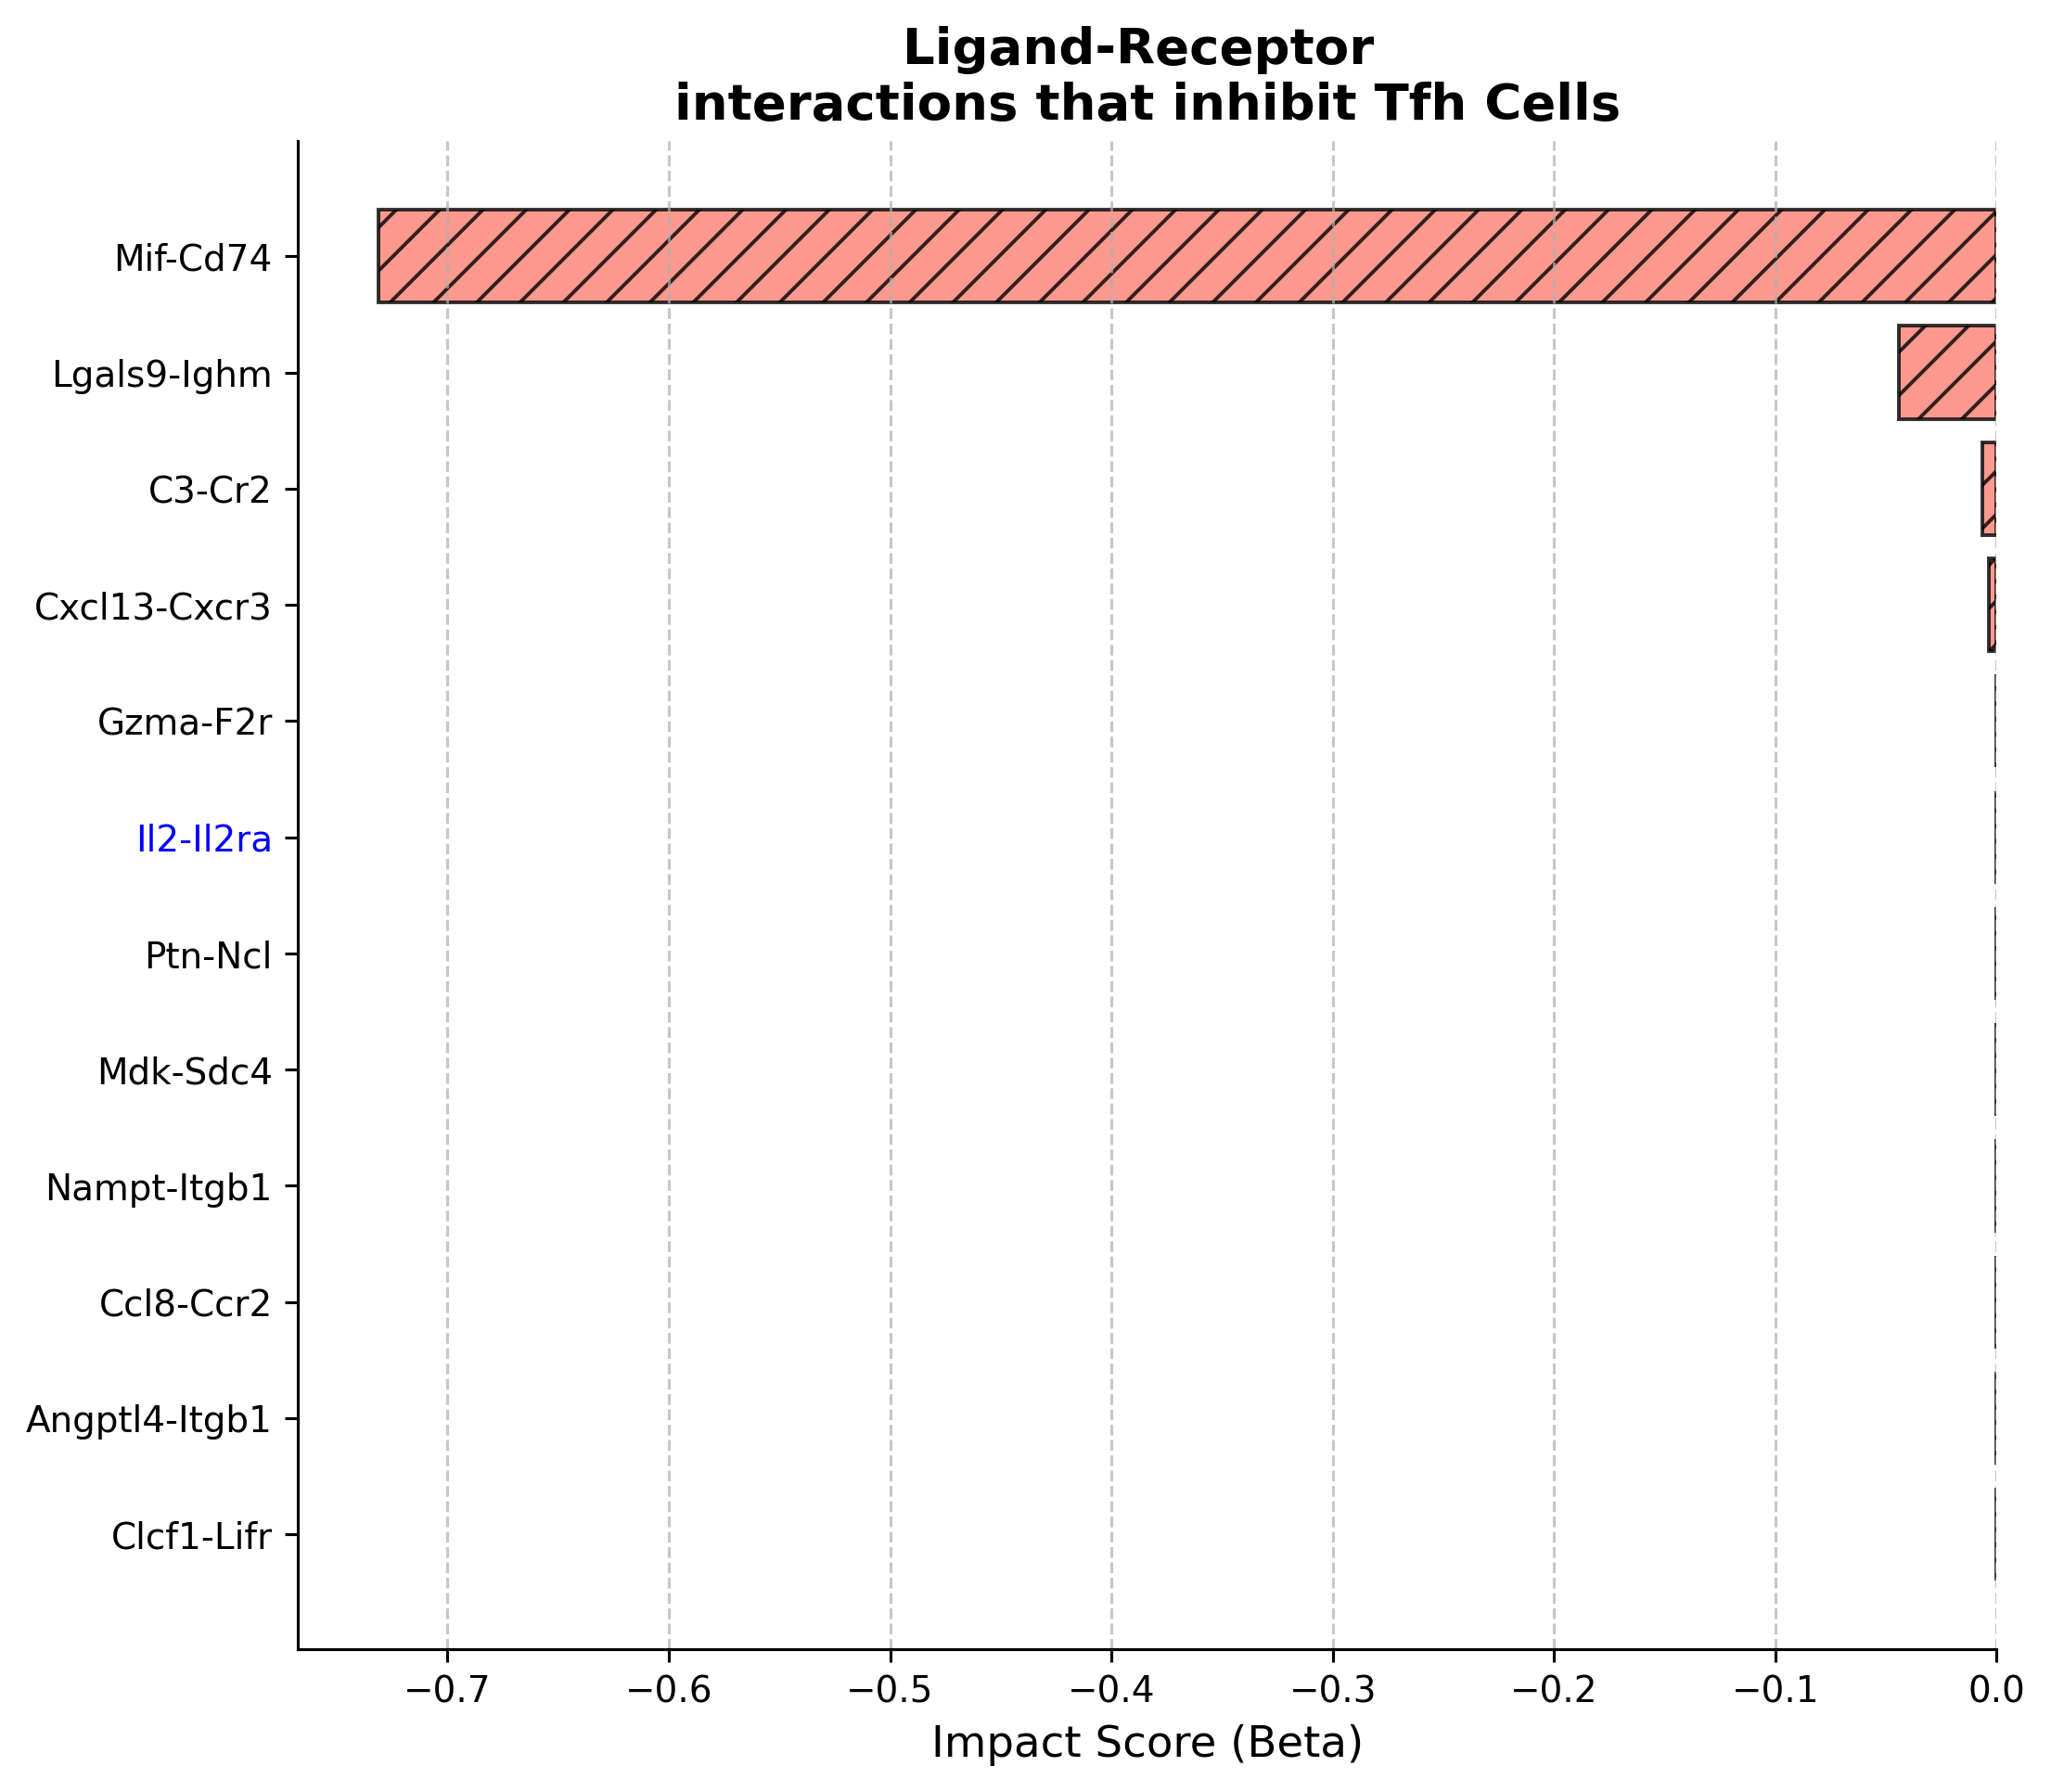

In [26]:
top_interactions = dfr[dfr['beta'] < 0].sort_values(
    by='beta', ascending=True).head(25)[::-1]

fig, ax = plt.subplots(figsize=(8, 7), dpi=140)
bars = ax.barh(top_interactions.index, top_interactions['beta'], 
    color='salmon', edgecolor='black', alpha=0.8, hatch='//')

ylabels = [label.get_text() for label in ax.get_yticklabels()]

for label in ylabels:
    if 'Ccr4' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('red')
        
    if 'Il2ra' in label or 'Il2rb' in label or 'Il2' in label:
        ax.get_yticklabels()[ylabels.index(label)].set_color('blue')
        
ax.set_xlabel('Impact Score (Beta)', fontsize=12)
ax.set_title('Ligand-Receptor \ninteractions that inhibit Tfh Cells', fontsize=14, fontweight='bold')
ax.grid(axis='x', linestyle='--', alpha=0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### Banksy

In [8]:
adata

AnnData object with n_obs × n_vars = 22227 × 3128
    obs: 'cell_type', 'cell_type_int', 'celltype_label_tangram', 'banksy_cluster'
    uns: 'cell_thresholds', 'cell_type_colors', 'cell_type_int_colors', 'received_ligands', 'received_ligands_tfl'
    obsm: 'X_spatial', 'spatial', 'spatial_unscaled', 'tangram_ct_pred'
    layers: 'imputed_count', 'normalized_count', 'raw_count'

In [9]:
from spaceoracle.beta import Betabase

ct = 'Th2'
bdb = Betabase(
    gf.adata[gf.adata.obs.cell_type == ct], 
    gf.save_dir, 
    subsample=None, 
    float16=True, 
    obs_names=gf.adata[gf.adata.obs.cell_type == ct].obs_names,
    auto_load=False
)

In [10]:
interactions = {}

for ct in [2, 7, 9]:
    interactions[ct] = bdb.collect_interactions(
        cell_type=ct, 
        annot='banksy_cluster')

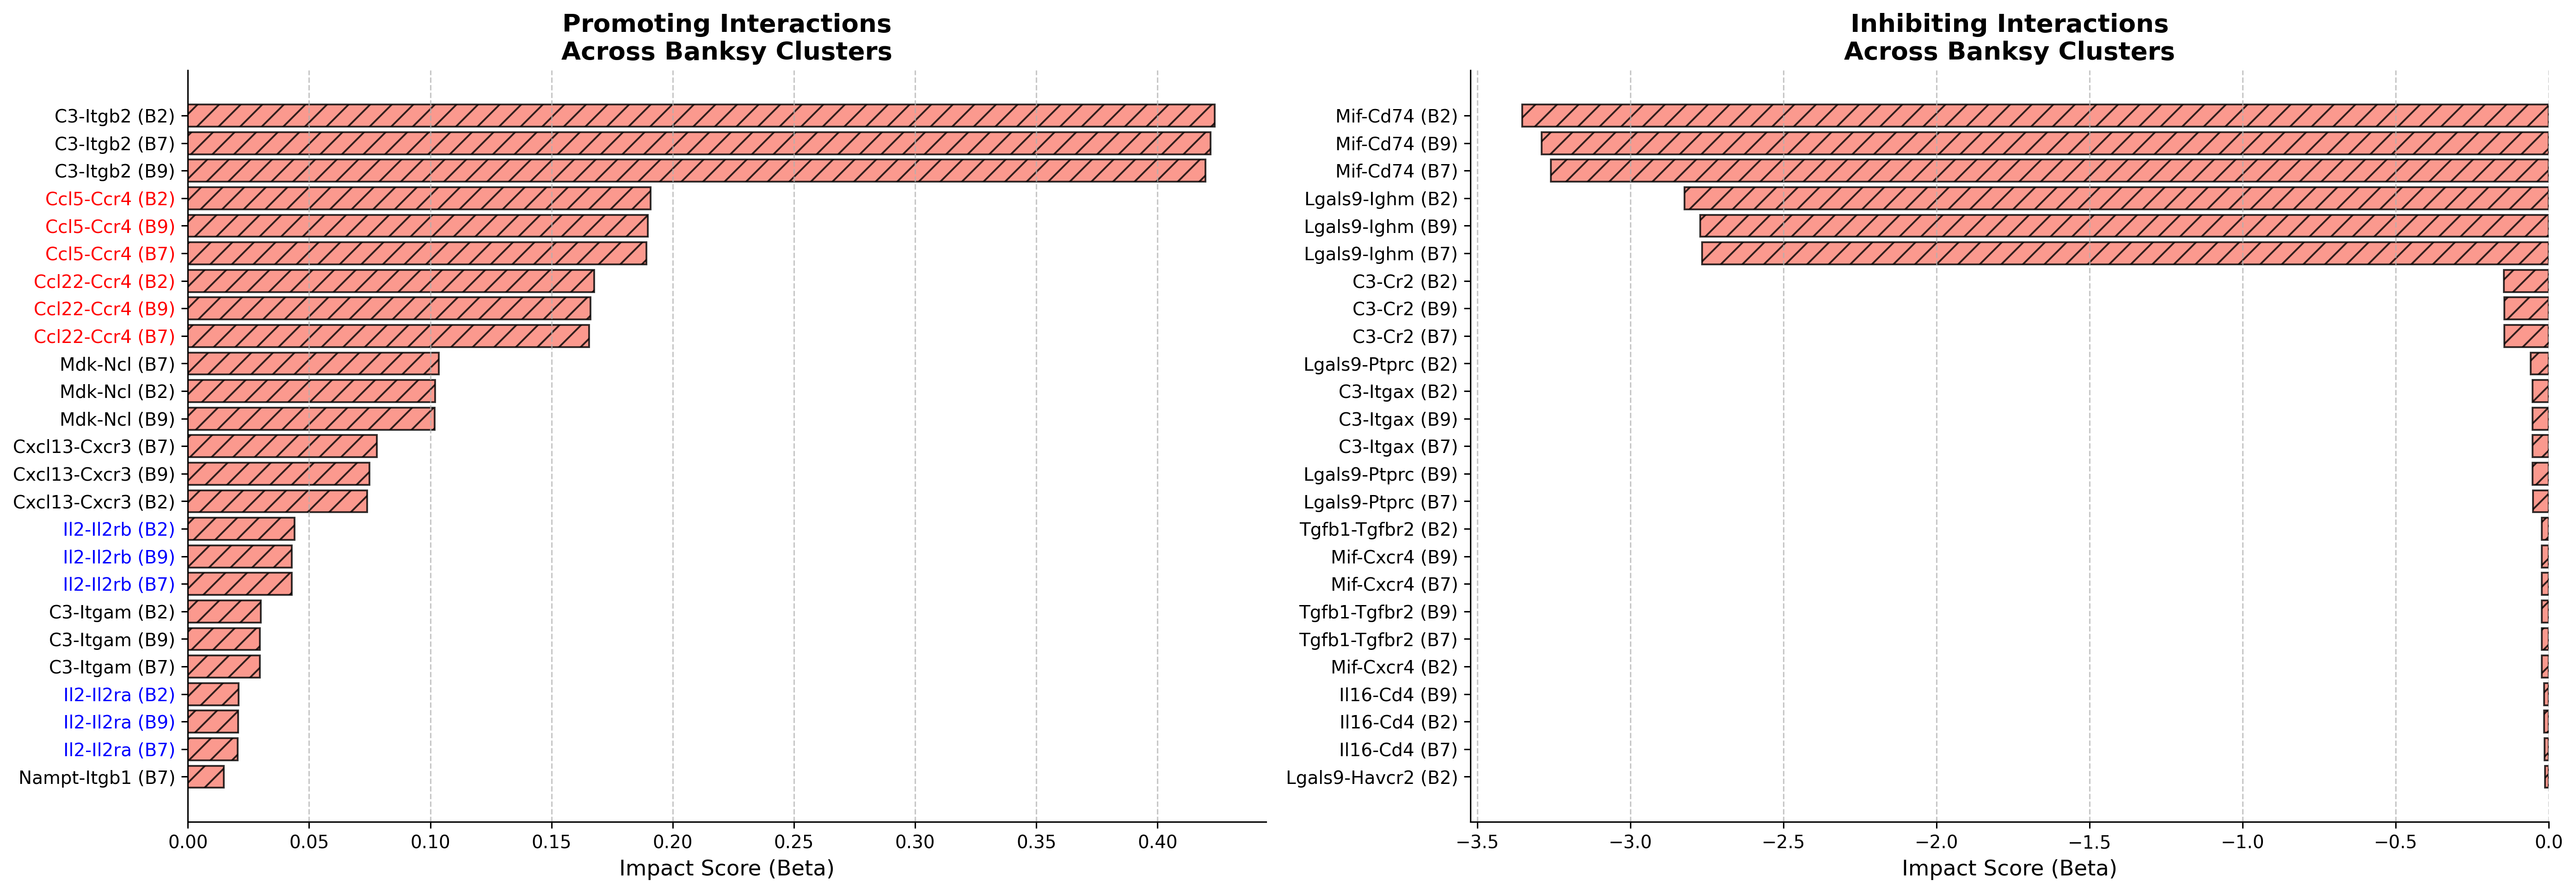

In [32]:
# 2, 7, 9
ct = 'Th2'

# Create two subplots - one for promoting and one for inhibiting interactions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7), dpi=140)

# Process data for all banksy clusters
all_promoting = []
all_inhibiting = []

for bct in [2, 7, 9]:
    dfr = interactions[bct][interactions[bct]['gene'].isin(['Gata3', 'Il2ra', 'Il2rb', 'Il2rg'])].groupby(
        'interaction').sum().sort_values(by='beta', ascending=False)
    
    dfr['beta'] = dfr['beta'] * 100
    dfr.index = dfr.index.str.replace('beta_', '').str.replace('$', '-')
    
    # Add banksy cluster info to index
    dfr.index = [f"{idx} (B{bct})" for idx in dfr.index]
    
    # Split into promoting and inhibiting
    promoting = dfr[dfr['beta'] > 0].sort_values(by='beta', ascending=False).head(25)
    inhibiting = dfr[dfr['beta'] < 0].sort_values(by='beta', ascending=True).head(25)
    
    all_promoting.append(promoting)
    all_inhibiting.append(inhibiting)

# Combine all promoting and inhibiting interactions
combined_promoting = pd.concat(all_promoting).sort_values(by='beta', ascending=False).head(25)[::-1]
combined_inhibiting = pd.concat(all_inhibiting).sort_values(by='beta', ascending=True).head(25)[::-1]

# Plot promoting interactions
bars1 = ax1.barh(combined_promoting.index, combined_promoting['beta'],
    color='salmon', edgecolor='black', alpha=0.8, hatch='//')

# Plot inhibiting interactions
bars2 = ax2.barh(combined_inhibiting.index, combined_inhibiting['beta'],
    color='salmon', edgecolor='black', alpha=0.8, hatch='//')

# Color labels for both plots
for ax in [ax1, ax2]:
    ylabels = [label.get_text() for label in ax.get_yticklabels()]
    for label in ylabels:
        if 'Ccr4' in label:
            ax.get_yticklabels()[ylabels.index(label)].set_color('red')
        if 'Il2ra' in label or 'Il2rb' in label or 'Il2' in label:
            ax.get_yticklabels()[ylabels.index(label)].set_color('blue')
    
    ax.set_xlabel('Impact Score (Beta)', fontsize=12)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax1.set_title('Promoting Interactions\nAcross Banksy Clusters', fontsize=14, fontweight='bold')
ax2.set_title('Inhibiting Interactions\nAcross Banksy Clusters', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()